## Importing libraries

In [1]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)
import itertools
import torch
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

## Defining helper functions

In case the user has a GPU, this will significantly speed up parameter optimization

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Function to import images

In [3]:
# desired size of the output image
imsize = 36

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

Get the images and label them

This code block makes use of the fact that images are within files whose filenames contain their labels; using the file extension to create a list of corresponding labels

In [4]:
label_list = []
for numeric_class in glob.glob("/home/jeremydiaz/deep_Devanagari/data/consonants/*"):
    label = numeric_class[-2:]
    for file_index in range(len(glob.glob(numeric_class + '/*'))):
        feature_image = glob.glob(numeric_class + '/*')[file_index]
        label_list.append(label)
        if label == label_list[0]:
            if file_index == 0:
                images = image_loader(feature_image)
            else:
                images = torch.cat([images, image_loader(feature_image).type(dtype)])
        else:
            images = torch.cat([images, image_loader(feature_image).type(dtype)])

### Quick visualization

The 123th image and its label

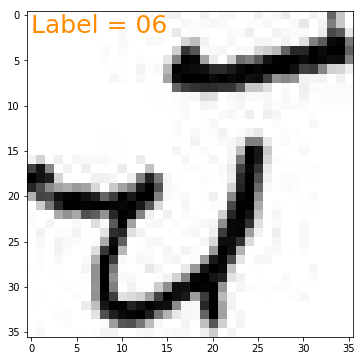

In [5]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(images[123].data.numpy().reshape((36,36)), cmap = 'gist_gray')
ax.annotate("Label = " + label_list[123], xy = (0, 2), color= 'darkorange', fontsize = 25)
plt.show()

# Getting the labels ready for PyTorch modelling
label_list = Variable(torch.from_numpy(np.asarray(label_list, dtype = np.float32)))

## Creating train and test sets

In [6]:
images_train, images_test, Y_train, Y_test = train_test_split(images.data.numpy(),
                                                              label_list.data.numpy(),
                                                              test_size = 0.25)

images_train = Variable(torch.from_numpy(images_train))
images_test = Variable(torch.from_numpy(images_test))

Y_train = (Y_train - 1)
Y_train = Variable(torch.from_numpy(Y_train)).type(torch.LongTensor)
Y_test = (Y_test - 1)
Y_test = Variable(torch.from_numpy(Y_test)).type(torch.LongTensor)

## Defining and training the model

Defining the CNN architecture, loss function, and parameter-updating method

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(9*9*32, 36)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
cnn = CNN()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())

The training

In [8]:
loss_list = []
test_loss_list = []
test_output_list = []

for epoch in range(201):
    
    minibatch_indices = torch.randperm(len(images_train))[0:50]
    
    minibatch_images = images_train[minibatch_indices]
    minibatch_Y = Y_train[minibatch_indices]

    optimizer.zero_grad()
    
    outputs = cnn(minibatch_images)
    test_outputs = cnn(images_test)
    
    loss = loss_function(outputs, minibatch_Y)
    test_loss = loss_function(test_outputs, Y_test)
    
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.data.numpy()[0])
    test_loss_list.append(test_loss.data.numpy()[0])
    
    if (epoch % 40) == 0:
        print('✓ Epoch %0.6f' % epoch)
        
    if epoch == 200:
        
        final_test_outputs = test_outputs.data.numpy()
        
Y_test_list = Y_test.data.numpy().tolist()

✓ Epoch 0.000000
✓ Epoch 40.000000
✓ Epoch 80.000000
✓ Epoch 120.000000
✓ Epoch 160.000000
✓ Epoch 200.000000


Visualization of the training

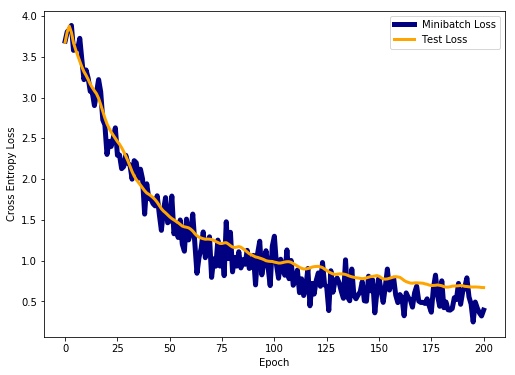

In [9]:
plt.plot(range(201), loss_list, c = 'navy', lw = 5, label = 'Minibatch Loss')
plt.plot(range(201), test_loss_list, c = 'orange', lw = 3, label = 'Test Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend();

## Evaluating performance

Predictions are currently in the form of confidence score arrays (length = 36), where true labels are single values (length = 1)

The next block converts the highest score's `range()` index into the single-value prediction

In [10]:
predicted_class_list = []

for instance_array in final_test_outputs:
    
    score_list = []
    
    for class_index in range(36):
        
        score_list.append(instance_array[class_index])
        
        score_array = np.asarray(score_list)
        
    highest_score = np.max(score_array)
    
    for class_index2 in range(36):
        
        if score_list[class_index2] == highest_score:
            
            predicted_class_list.append(class_index2)

### Confusion matrix

The confusion matrix is actually too large to view well, so get rid for some `print()`s!

Converting arbitrary labels to their Devanagari characters

In [11]:
label_dict = {0 : 'क', 1 : 'ख', 2 : 'ग', 3 : 'घ', 4 : 'ङ',
              5 : 'च', 6 : 'छ', 7 : 'ज', 8 : 'झ', 9 : 'ञ',
              10 : 'ट', 11 : 'ठ', 12 : 'ड', 13 : 'ढ', 14 : 'ण',
              15 : 'त', 16 : 'थ', 17 : 'द', 18 : 'ध', 19 : 'न',
              20 : 'प', 21 : 'फ', 22 : 'ब', 23 : 'भ', 24 : 'म',
              25 : 'य', 26 : 'र', 27 : 'ल', 28 : 'व', 29 : 'श',
              30 : 'ष', 31 : 'स', 32 : 'ह', 33 : 'क्ष', 34 : 'त्र',
              35 : 'ज्ञ'}

Printing out accuracy by class, whether the correct label was the most predicted by class, and what the most often confused label was

In [12]:
for y in range(36):
    print('-----------------------------------------------------------')
    print('For class ' + label_dict[y] +  ', prediction accuracy was...')
    print(confusion_matrix(Y_test_list, predicted_class_list)[y][y] / sum(confusion_matrix(Y_test_list, predicted_class_list)[y]))
    most_predicted_by_label = np.argsort(confusion_matrix(Y_test_list, predicted_class_list)[y])[-1]
    if y == most_predicted_by_label:
        print(label_dict[y] + ' is, in fact, the most predicted label for this class')
        second_most_predicted_by_label = np.argsort(confusion_matrix(Y_test_list, predicted_class_list)[y])[-2]
        print(label_dict[y] + ' is most often confused with ' + label_dict[second_most_predicted_by_label])
        print('    this confusion occurs %0.6f of the time' % (confusion_matrix(Y_test_list, predicted_class_list)[y][second_most_predicted_by_label] / sum(confusion_matrix(Y_test_list, predicted_class_list)[y])))
    else:
        print('WARNING')
        print('THIS CLASS HAS PARTICULARLY POOR PERFORMANCE')
    print('')

-----------------------------------------------------------
For class क, prediction accuracy was...
0.901960784314
क is, in fact, the most predicted label for this class
क is most often confused with फ
    this confusion occurs 0.078431 of the time

-----------------------------------------------------------
For class ख, prediction accuracy was...
0.895833333333
ख is, in fact, the most predicted label for this class
ख is most often confused with ज्ञ
    this confusion occurs 0.020833 of the time

-----------------------------------------------------------
For class ग, prediction accuracy was...
0.75
ग is, in fact, the most predicted label for this class
ग is most often confused with ण
    this confusion occurs 0.102941 of the time

-----------------------------------------------------------
For class घ, prediction accuracy was...
0.717391304348
घ is, in fact, the most predicted label for this class
घ is most often confused with ध
    this confusion occurs 0.108696 of the time

--------

### Accuracy

In [13]:
print("This convolutional neural network was able classify Devanagari consonants with %0.6f" % (accuracy_score(Y_test_list, predicted_class_list) * 100) + "% accuracy!")

This convolutional neural network was able classify Devanagari consonants with 79.945799% accuracy!


## Performance gallery

Plotting 3 randomly selected test set images, along with their true and predicted labels

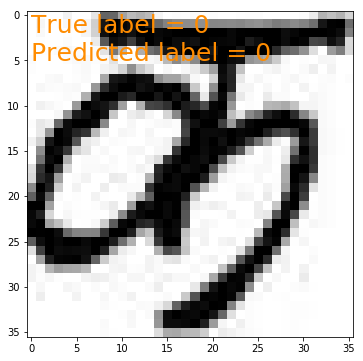

In [14]:
# The random selection
randomized_index = np.random.choice(len(images_test))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(images_test[randomized_index].data.numpy().reshape((36, 36)), cmap = 'gist_gray')
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'darkorange', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'darkorange', fontsize = 25)
plt.show()

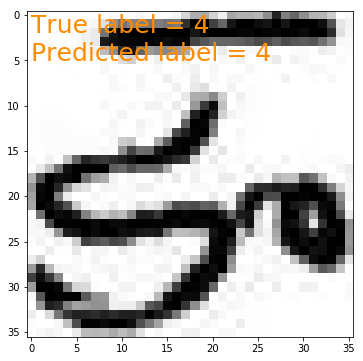

In [15]:
# The random selection
randomized_index = np.random.choice(len(images_test))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(images_test[randomized_index].data.numpy().reshape((36, 36)), cmap = 'gist_gray')
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'darkorange', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'darkorange', fontsize = 25)
plt.show()

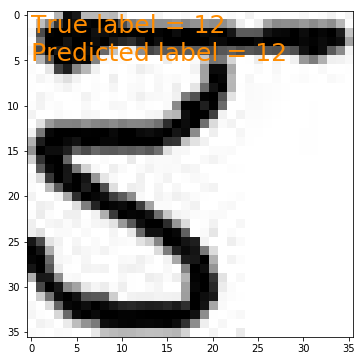

In [16]:
# The random selection
randomized_index = np.random.choice(len(images_test))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(images_test[randomized_index].data.numpy().reshape((36, 36)), cmap = 'gist_gray')
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'darkorange', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'darkorange', fontsize = 25)
plt.show()